In [41]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow ta

In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import ta

In [43]:
def get_historical_prices(symbol, period="24mo"):
    stock = yf.Ticker(symbol)
    hist = stock.history(period=period)
    if not hist.empty:
        if 'Close' in hist.columns:
            return hist
        else:
            print("Error: La columna 'Close' no se encuentra en los datos históricos.")
            return None
    else:
        print('Error al obtener los datos históricos.')
        return None

In [44]:
def create_dataset(prices, look_back=60):
    dataX, dataY = [], []
    for i in range(len(prices) - look_back):
        a = prices[i:(i + look_back)]
        dataX.append(a)
        dataY.append(prices[i + look_back])
    return np.array(dataX), np.array(dataY)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def add_indicators(df):
    if isinstance(df, pd.DataFrame) and 'Close' in df.columns:
        # Adding MACD
        df['MACD'] = ta.trend.macd(df['Close'])
        df['MACD_Signal'] = ta.trend.macd_signal(df['Close'])

        # Adding Bollinger Bands
        bb = ta.volatility.BollingerBands(df['Close'])
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Adding RSI
        df['RSI'] = ta.momentum.rsi(df['Close'])

        return df
    else:
        raise ValueError("El DataFrame no tiene la columna 'Close'.")

def plot_predictions(df, actual_prices, predicted_prices, symbol):
    plt.figure(figsize=(14, 10))

    # Plot actual and predicted prices
    plt.subplot(4, 1, 1)
    plt.plot(df.index, df['Close'], label='Precio Actual')
    plt.plot(df.index[-len(predicted_prices):], predicted_prices, label='Precio Predicho', linestyle='dashed')
    plt.title(f'Análisis de Trading para {symbol}')
    plt.ylabel('Precio de Cierre')
    plt.legend()

    # Plot MACD
    plt.subplot(4, 1, 2)
    plt.plot(df.index, df['MACD'], label='MACD')
    plt.plot(df.index, df['MACD_Signal'], label='MACD Signal')
    plt.title('MACD')
    plt.legend()

    # Plot Bollinger Bands and RSI
    plt.subplot(4, 1, 3)
    plt.plot(df.index, df['Close'], label='Precio Actual')
    plt.plot(df.index, df['BB_High'], label='Banda Superior', linestyle='dashed')
    plt.plot(df.index, df['BB_Low'], label='Banda Inferior', linestyle='dashed')
    plt.title('Bandas de Bollinger y RSI')
    plt.legend(loc='upper left')

    ax2 = plt.gca().twinx()
    ax2.plot(df.index, df['RSI'], label='RSI', color='purple', alpha=0.3)
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')
    ax2.axhline(30, linestyle='--', alpha=0.5, color='green')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper right')

    # Plot Fibonacci Retracement
    plt.subplot(4, 1, 4)
    max_price = df['Close'].max()
    min_price = df['Close'].min()
    diff = max_price - min_price
    levels = [max_price - diff * ratio for ratio in [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]]
    for level in levels:
        plt.axhline(level, linestyle='--', alpha=0.5, color='orange')
    plt.plot(df.index, df['Close'], label='Precio Actual')
    plt.title('Retrocesos de Fibonacci')
    plt.legend()

    plt.tight_layout()
    plt.show()

***INPUT ACCIÓN Y OUTPUT MEJOR PRECIO DE COMPRA***

In [47]:
if __name__ == '__main__':
    # Verificar si TensorFlow está utilizando la GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)

    symbol = input('Ingrese el símbolo de la acción: ')
    df = get_historical_prices(symbol, period="24mo")

    if df is not None:
        df = add_indicators(df)

        # Normalizar los datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

        # Crear el conjunto de datos
        look_back = 60
        X, y = create_dataset(scaled_data, look_back)

        # Dividir el conjunto de datos en entrenamiento y prueba
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Redimensionar los datos para que sean compatibles con el LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Construir el modelo LSTM
        model = build_lstm_model((X_train.shape[1], 1))

        # Entrenar el modelo
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        # Realizar predicciones
        predicted_prices = model.predict(X_test)
        predicted_prices = scaler.inverse_transform(predicted_prices)
        actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Obtener el precio actual de la acción
        current_price = yf.Ticker(symbol).history(period='1d')['Close'].iloc[0]

        # Mostrar el precio actual y el mejor precio de compra predicho
        print(f'El mejor precio de compra es: {np.min(predicted_prices)}')
        print(f'El precio actual de la acción {symbol} es: {current_price}')

Ingrese el símbolo de la acción: aapl


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
El mejor precio de compra predicho es: 224.63026428222656
El precio actual de la acción aapl es: 242.64500427246094


***GRÁFICO ANÁLISIS***

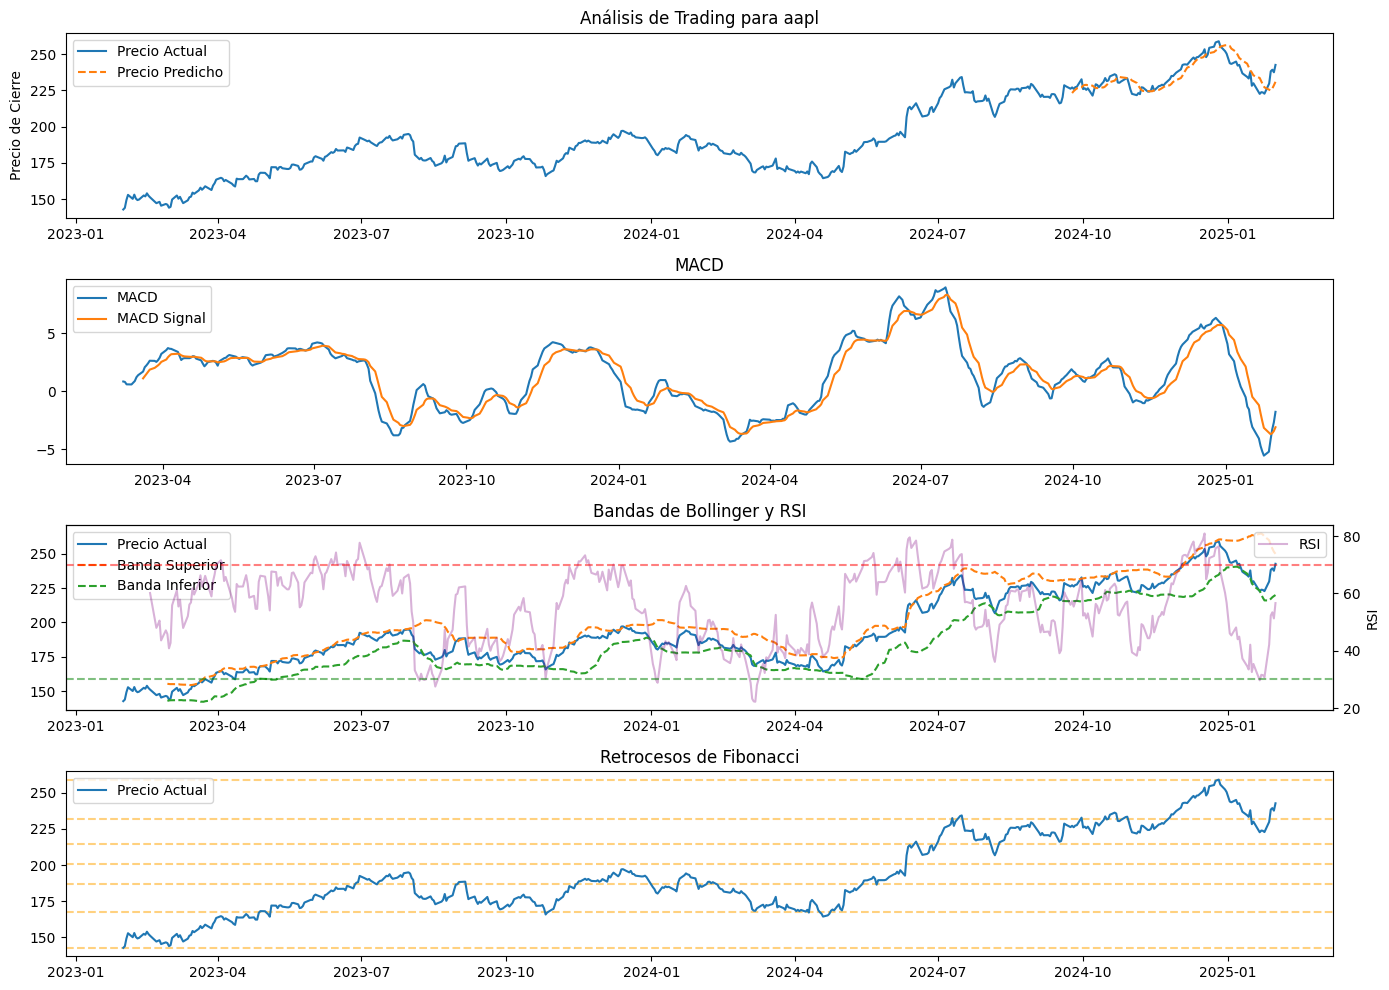

In [46]:
plot_predictions(df, actual_prices, predicted_prices, symbol)